# Matched Discrimination Gender Analysis

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression


## Load in data if pipeline has already been run through

In [3]:
_dir = '/Users/prachi/Documents/depth_duration/depth_discrimination'
# raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalDiscrimMatched/z_scored_RT/'

# final_data = pd.read_csv (raw_dir + '/raw_discrim.csv')
zscored_data = pd.read_csv (zs_dir + 'final_discrim.csv')

In [6]:
m_zscored_data = zscored_data.loc[zscored_data['gender']=='Man']
w_zscored_data = zscored_data.loc[zscored_data['gender']=='Woman']

# Correlation with Verbal Report data 

- For each discrimination trial, get the average difference between the verbal report for those scenes 
- Correlate that with the proportion correct for that trial 
- Is there better accuracy for scenes that have a larger percevied depth difference (using the verbal report data)?

## Individual Discriminations

In [8]:
def get_accuracy(df):
    """
    * ACCURACY BASED ON THE KINECT
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    
    return count_correct/count_total, count_correct, count_total, count_missed

def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        list_RTs.append(row["trial_RT"])
    
    list_RTs = np.array(list_RTs)
    
    return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

In [8]:
final_discrim = zscored_data

In [9]:
overall_accuracy = get_accuracy(final_discrim)
overall_accuracy

(0.5848045105832332, 6327, 10819, 100)

In [10]:
print(get_accuracy(m_zscored_data), get_accuracy(w_zscored_data))

(0.5953159615993249, 11286, 18958, 216) (0.5932171276998863, 9393, 15834, 277)


In [11]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str]

    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        
        try:
            stim_acc_125 = get_accuracy(stim_125_df)
            stim_acc_250 = get_accuracy(stim_250_df)
            stim_acc_1000 = get_accuracy(stim_1000_df)

            stim_RT_125 = get_RT(stim_125_df)
            stim_RT_250 = get_RT(stim_250_df)
            stim_RT_1000 = get_RT(stim_1000_df)

            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        except:
            pass
    
    return stimuli_stats

In [18]:
m_all_discrim_performance = individual_discrimination_stats(m_zscored_data)
w_all_discrim_performance = individual_discrimination_stats(w_zscored_data)
all_discrim_performance = individual_discrimination_stats(zscored_data)


In [308]:
# all_discrim_performance['depth_discrimination_stimuli/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5/001417_2014-06-19_16-25-36_260595134347_rgbf000115-resize_5-target.png']



## Load Z-scored TAC Verbal Judgement Data


In [19]:
p = '/Users/prachi/Documents/depth_duration/verbal_judgement_analysis/data/finalVEMatched/z_scored/'

# x data
with open(p + 'X_125.npy' , 'rb') as f:
    n_TAC_X_125 = np.load(f, allow_pickle=True)
    
with open(p + 'X_250.npy' , 'rb') as f:
    n_TAC_X_250 = np.load(f, allow_pickle=True)

with open(p + 'X_1000.npy' , 'rb') as f:
    n_TAC_X_1000 = np.load(f, allow_pickle=True)
    
# y data 
with open(p + 'z_final_y_125.npy' , 'rb') as f:
    n_TAC_final_y_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_250.npy' , 'rb') as f:
    n_TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_y_1000.npy' , 'rb') as f:
    n_TAC_final_y_1000= np.load(f, allow_pickle=True)

# std data
with open(p + 'z_std_125.npy' , 'rb') as f:
    n_TAC_std_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_std_250.npy' , 'rb') as f:
    n_TAC_std_250 = np.load(f, allow_pickle=True)

with open(p + 'z_std_1000.npy' , 'rb') as f:
    n_TAC_std_1000 = np.load(f, allow_pickle=True)
    
# ste data
with open(p + 'z_ste_125.npy' , 'rb') as f:
    n_TAC_ste_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_ste_250.npy' , 'rb') as f:
    n_TAC_ste_250 = np.load(f, allow_pickle=True)

with open(p + 'z_ste_1000.npy' , 'rb') as f:
    n_TAC_ste_1000 = np.load(f, allow_pickle=True)

# stim data
with open(p + 'z_final_stim_125.npy' , 'rb') as f:
    n_TAC_final_stim_125 = np.load(f, allow_pickle=True)
    
with open(p + 'z_final_stim_250.npy' , 'rb') as f:
    n_TAC_final_stim_250 = np.load(f, allow_pickle=True)

with open(p + 'z_final_stim_1000.npy' , 'rb') as f:
    n_TAC_final_stim_1000 = np.load(f, allow_pickle=True)

# Code depth discrimination correctness by the verbal judgement data 

Create new 'ground truth' answer based on verbal judgement data

Task: Respond which image's target was closer to you

## VE Data

In [20]:
n_VE_answerkey_125 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_125 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_125[idx0]
    std0 = n_TAC_std_125[idx0]
    ste0 = n_TAC_ste_125[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_125 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_125[idx1]
    std1 = n_TAC_std_125[idx1]
    ste1 = n_TAC_ste_125[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_125[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}

In [21]:
n_VE_answerkey_250 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_250[idx0]
    std0 = n_TAC_std_250[idx0]
    ste0 = n_TAC_ste_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_250[idx1]
    std1 = n_TAC_std_250[idx1]
    ste1 = n_TAC_ste_250[idx1]
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    n_VE_answerkey_250[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [22]:
n_VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(n_TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = n_TAC_final_y_1000[idx0]
    std0 = n_TAC_std_1000[idx0]

    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(n_TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = n_TAC_final_y_1000[idx1]
    std1 = n_TAC_std_1000[idx1]
    
    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1
    
    kinect_answer = all_discrim_performance[key]['kinect_answer'].split('/')[-1]



    n_VE_answerkey_1000[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1,
                             'kinect_answer': kinect_answer}
    

In [23]:
len(n_VE_answerkey_1000)

156

In [20]:
import pickle
# save answer keys as pickle file 

# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_1000.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_1000, handle)

In [21]:
# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/TAC_discrim_datafiles/matched_discrim_data/n_VE_answerkey_250.pickle'
# with open(dest, 'wb') as handle:
#     pickle.dump(n_VE_answerkey_250, handle)

### VE Coded Accuracy

In [24]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    kinect_correct_answer = answerkey[stim0]['kinect_answer']
    
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
#     standardError = (0.5*(1-0.5))/count_total
    p = count_correct/count_total
    standardError = np.sqrt((p*(1-p))/count_total)
    
    if VE_correct_answer == kinect_correct_answer:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'pos'
    else:
        return count_correct/count_total, count_correct, count_total, count_missed, standardError, 'neg'

    
def main_VE_accuracy(df, answerkey_125, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        try:
            # dataframe for stimulus 0
            stim0_df = df.loc[df['stimulus_0'] == stim0]
            # name of stimulus 1
            other_stim = stim0_df.stimulus_1.unique()[0]
            # dataframe where stimulus 0 is presented SECOND (same trial)
            stim1_df = df.loc[df['stimulus_1'] == stim0]

            # df for a specific discrimination trial (collapsed on stim presentation order)
            stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
            stim_125_df = stim_df[stim_df['duration'] == 125.0]
            stim_250_df = stim_df[stim_df['duration'] == 250.0]
            stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 

            stim0_depth = stim_df['actual_depth_0'][0]
            stim1_depth = stim_df['actual_depth_1'][0]
            stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))

            stim_acc_125 = VE_accuracy(stim0, stim_125_df, answerkey_125)
            stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
            stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)

            # difference between verbal judgements divided by joint variance 
            # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
            std0_125 = answerkey_125[stim0]['std0']
            std1_125 = answerkey_125[stim0]['std1']
            joint_variance_125 = np.sqrt(std0_125**2 + std1_125**2)
            JV_regressor_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])/joint_variance_125

            std0_250 = answerkey_250[stim0]['std0']
            std1_250 = answerkey_250[stim0]['std1']
            joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
            JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250

            std0_1000 = answerkey_1000[stim0]['std0']
            std1_1000 = answerkey_1000[stim0]['std1']
            joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
            JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
            
            if stim_acc_125[-1] == 'pos':
                VE_depthdifference_125 = abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_125 = -(abs(answerkey_125[stim0]['stimulus_0_avg_estim'] - answerkey_125[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_250[-1] == 'pos':
                VE_depthdifference_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_250 = -(abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']))
            
            if stim_acc_1000[-1] == 'pos':
                VE_depthdifference_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])
            else:
                VE_depthdifference_1000 = -(abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']))
            
            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'accuracy_250': stim_acc_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'avg_depth': stim_depthbin,
                                    'VE_depthdifference_125': VE_depthdifference_125, 
                                    'VE_depthdifference_250': VE_depthdifference_250, 
                                    'VE_depthdifference_1000': VE_depthdifference_1000,
                                    'RT_125': get_RT(stim_125_df),
                                    'RT_250': get_RT(stim_250_df),
                                    'RT_1000': get_RT(stim_1000_df),
                                    'JV_regressor_125': JV_regressor_125,
                                    'JV_regressor_250': JV_regressor_250,
                                    'JV_regressor_1000': JV_regressor_1000,
                                    'kinect_answer_125': answerkey_125[stim0]['kinect_answer'],
                                    'kinect_answer_250': answerkey_250[stim0]['kinect_answer'],
                                    'kinect_answer_1000': answerkey_1000[stim0]['kinect_answer']}
            

        except:
            print(stim0)

    return stimuli_stats
    

In [25]:
men_n_all_VE_discrim_performance = main_VE_accuracy(m_zscored_data, n_VE_answerkey_125, n_VE_answerkey_250, n_VE_answerkey_1000)

women_n_all_VE_discrim_performance = main_VE_accuracy(w_zscored_data, n_VE_answerkey_125, n_VE_answerkey_250, n_VE_answerkey_1000)


nan
nan


In [26]:
len(men_n_all_VE_discrim_performance), len(women_n_all_VE_discrim_performance)



(156, 156)

In [27]:
# import pickle
# # save performance as pickle file 

# dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/'
# with open(dest + 'performance.pkl', 'wb') as handle:
#     pickle.dump(n_all_VE_discrim_performance, handle)
    

In [30]:
men_n_VE_estim_diff_125 = [men_n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in men_n_all_VE_discrim_performance]
men_n_VE_estim_diff_250 = [men_n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in men_n_all_VE_discrim_performance]
men_n_VE_estim_diff_1000 = [men_n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in men_n_all_VE_discrim_performance]

men_n_VE_accuracy_125 = [men_n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in men_n_all_VE_discrim_performance]
men_n_VE_accuracy_250 = [men_n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in men_n_all_VE_discrim_performance]
men_n_VE_accuracy_1000 = [men_n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in men_n_all_VE_discrim_performance]

men_n_VE_ste_125 = [men_n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in men_n_all_VE_discrim_performance]
men_n_VE_ste_250 = [men_n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in men_n_all_VE_discrim_performance]
men_n_VE_ste_1000 = [men_n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in men_n_all_VE_discrim_performance]

men_n_avg_RT_125 = [men_n_all_VE_discrim_performance[elem]['RT_125'][1] for elem in men_n_all_VE_discrim_performance]
men_n_avg_RT_250 = [men_n_all_VE_discrim_performance[elem]['RT_250'][1] for elem in men_n_all_VE_discrim_performance]
men_n_avg_RT_1000 = [men_n_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in men_n_all_VE_discrim_performance]

men_n_avg_RT_ste_125 = [men_n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in men_n_all_VE_discrim_performance]
men_n_avg_RT_ste_250 = [men_n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in men_n_all_VE_discrim_performance]
men_n_avg_RT_ste_1000 = [men_n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in men_n_all_VE_discrim_performance]

men_n_JV_125 = [men_n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in men_n_all_VE_discrim_performance]
men_n_JV_250 = [men_n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in men_n_all_VE_discrim_performance]
men_n_JV_1000 = [men_n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in men_n_all_VE_discrim_performance]

men_n_kinectanswer_125 = [men_n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in men_n_all_VE_discrim_performance]
men_n_kinectanswer_250 = [men_n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in men_n_all_VE_discrim_performance]
men_n_kinectanswer_1000 = [men_n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in men_n_all_VE_discrim_performance]

men_n_stim = [elem for elem in men_n_all_VE_discrim_performance]

In [31]:
women_n_VE_estim_diff_125 = [women_n_all_VE_discrim_performance[elem]['VE_depthdifference_125'] for elem in women_n_all_VE_discrim_performance]
women_n_VE_estim_diff_250 = [women_n_all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in women_n_all_VE_discrim_performance]
women_n_VE_estim_diff_1000 = [women_n_all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in women_n_all_VE_discrim_performance]

women_n_VE_accuracy_125 = [women_n_all_VE_discrim_performance[elem]['accuracy_125'][0] for elem in women_n_all_VE_discrim_performance]
women_n_VE_accuracy_250 = [women_n_all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in women_n_all_VE_discrim_performance]
women_n_VE_accuracy_1000 = [women_n_all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in women_n_all_VE_discrim_performance]

women_n_VE_ste_125 = [women_n_all_VE_discrim_performance[elem]['accuracy_125'][-2] for elem in women_n_all_VE_discrim_performance]
women_n_VE_ste_250 = [women_n_all_VE_discrim_performance[elem]['accuracy_250'][-2] for elem in women_n_all_VE_discrim_performance]
women_n_VE_ste_1000 = [women_n_all_VE_discrim_performance[elem]['accuracy_1000'][-2] for elem in women_n_all_VE_discrim_performance]

women_n_avg_RT_125 = [women_n_all_VE_discrim_performance[elem]['RT_125'][1] for elem in women_n_all_VE_discrim_performance]
women_n_avg_RT_250 = [women_n_all_VE_discrim_performance[elem]['RT_250'][1] for elem in women_n_all_VE_discrim_performance]
women_n_avg_RT_1000 = [women_n_all_VE_discrim_performance[elem]['RT_1000'][1] for elem in women_n_all_VE_discrim_performance]

women_n_avg_RT_ste_125 = [women_n_all_VE_discrim_performance[elem]['RT_125'][-1] for elem in women_n_all_VE_discrim_performance]
women_n_avg_RT_ste_250 = [women_n_all_VE_discrim_performance[elem]['RT_250'][-1] for elem in women_n_all_VE_discrim_performance]
women_n_avg_RT_ste_1000 = [women_n_all_VE_discrim_performance[elem]['RT_1000'][-1] for elem in women_n_all_VE_discrim_performance]

women_n_JV_125 = [women_n_all_VE_discrim_performance[elem]['JV_regressor_125'] for elem in women_n_all_VE_discrim_performance]
women_n_JV_250 = [women_n_all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in women_n_all_VE_discrim_performance]
women_n_JV_1000 = [women_n_all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in women_n_all_VE_discrim_performance]

women_n_kinectanswer_125 = [women_n_all_VE_discrim_performance[elem]['kinect_answer_125'] for elem in women_n_all_VE_discrim_performance]
women_n_kinectanswer_250 = [women_n_all_VE_discrim_performance[elem]['kinect_answer_250'] for elem in women_n_all_VE_discrim_performance]
women_n_kinectanswer_1000 = [women_n_all_VE_discrim_performance[elem]['kinect_answer_1000'] for elem in women_n_all_VE_discrim_performance]

women_n_stim = [elem for elem in women_n_all_VE_discrim_performance]

## Accuracy x Gender

In [38]:
len(m_zscored_data.subjID.unique()), len(w_zscored_data.subjID.unique())

(247, 208)

In [41]:
np.mean(men_n_VE_accuracy_125), np.mean(men_n_VE_accuracy_250), np.mean(men_n_VE_accuracy_1000)

(0.6719937497431988, 0.7057487048627931, 0.7480192468350364)

In [42]:
np.mean(women_n_VE_accuracy_125), np.mean(women_n_VE_accuracy_250), np.mean(women_n_VE_accuracy_1000)

(0.6819865314511273, 0.7354939839853634, 0.760930279219753)

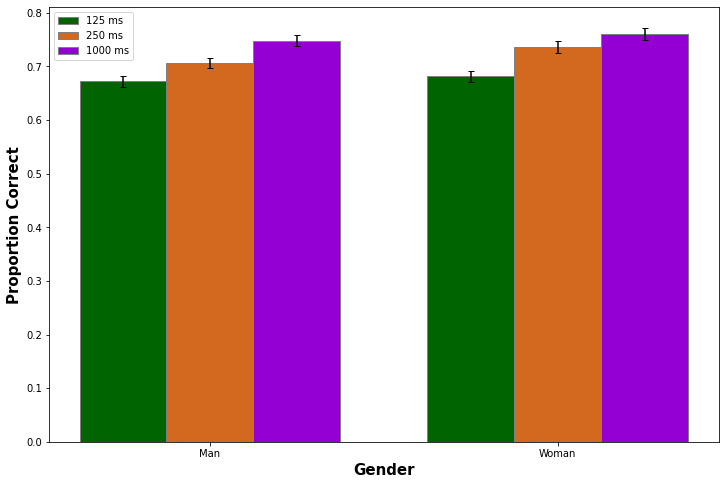

In [51]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
ms125 = [np.mean(men_n_VE_accuracy_125), np.mean(women_n_VE_accuracy_125)]
ms250 = [np.mean(men_n_VE_accuracy_250), np.mean(women_n_VE_accuracy_250)]
ms1000 = [np.mean(men_n_VE_accuracy_1000), np.mean(women_n_VE_accuracy_1000)]
 
# Set position of bar on X axis
br1 = np.arange(len(ms125))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, ms125, color ='darkgreen', width = barWidth,yerr = [sem(men_n_VE_accuracy_125),sem(women_n_VE_accuracy_125)],
        edgecolor ='grey', label ='125 ms', capsize=3)
plt.bar(br2, ms250, color ='chocolate', width = barWidth,yerr = [sem(men_n_VE_accuracy_250),sem(women_n_VE_accuracy_250)],
        edgecolor ='grey', label ='250 ms', capsize=3)
plt.bar(br3, ms1000, color ='darkviolet', width = barWidth,yerr = [sem(men_n_VE_accuracy_1000),sem(women_n_VE_accuracy_1000)],
        edgecolor ='grey', label ='1000 ms', capsize=3)
 
# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Proportion Correct', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Man', 'Woman'])
 
plt.legend()
plt.show()

In [55]:
men_accSlope_125 = LinearRegression().fit(np.array(np.abs(men_n_VE_estim_diff_125).reshape(-1,1)), men_n_VE_accuracy_125).coef_[0]
men_accSlope_250 = LinearRegression().fit(np.array(np.abs(men_n_VE_estim_diff_250).reshape(-1,1)), men_n_VE_accuracy_250).coef_[0]
men_accSlope_1000 = LinearRegression().fit(np.array(np.abs(men_n_VE_estim_diff_1000).reshape(-1,1)), men_n_VE_accuracy_1000).coef_[0]


women_accSlope_125 = LinearRegression().fit(np.array(np.abs(women_n_VE_estim_diff_125).reshape(-1,1)), women_n_VE_accuracy_125).coef_[0]
women_accSlope_250 = LinearRegression().fit(np.array(np.abs(women_n_VE_estim_diff_250).reshape(-1,1)), women_n_VE_accuracy_250).coef_[0]
women_accSlope_1000 = LinearRegression().fit(np.array(np.abs(women_n_VE_estim_diff_1000).reshape(-1,1)), women_n_VE_accuracy_1000).coef_[0]


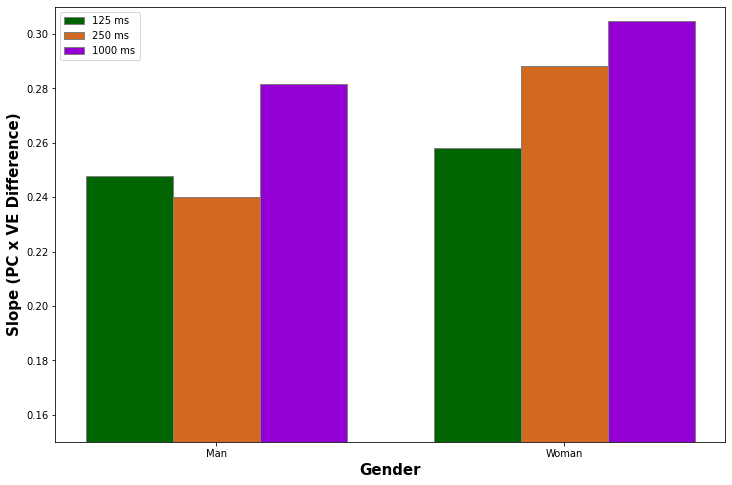

In [61]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
ms125 = [men_accSlope_125, women_accSlope_125]
ms250 = [men_accSlope_250, women_accSlope_250]
ms1000 = [men_accSlope_1000, women_accSlope_1000]
 
# Set position of bar on X axis
br1 = np.arange(len(ms125))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, ms125, color ='darkgreen', width = barWidth,
        edgecolor ='grey', label ='125 ms', capsize=3)
plt.bar(br2, ms250, color ='chocolate', width = barWidth,
        edgecolor ='grey', label ='250 ms', capsize=3)
plt.bar(br3, ms1000, color ='darkviolet', width = barWidth,
        edgecolor ='grey', label ='1000 ms', capsize=3)
 
# Adding Xticks
plt.xlabel('Gender', fontweight ='bold', fontsize = 15)
plt.ylabel('Slope (PC x VE Difference)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(2)],
        ['Man', 'Woman'])

plt.ylim(0.15, 0.31)
 
plt.legend()
plt.show()